# Attributable Protein Language Model (ESMattribution)
This notebook demonstrates training and getting per residue attribution from and ESM2 based model fine-tuned to predict a binary classification.  The demonstration uses RNA binding predictions from RNApred (https://webs.iiitd.edu.in/raghava/rnapred/download.html).  If the sequence id is a uniprot id, the code can download the alphafold prediction and display the per residue RNA binding attribution as a false color.  This code can be run google colab at this link:
http://colab.research.google.com/github/jayunruh/ESMattribution/blob/main/train_attribute_rna_binding.ipynb

In [1]:
#if you are using this from google colab, you need the utility modules
#(everything else should already be installed)
!pip install py3dmol
import os
if(not os.path.exists('model_utils.py')):
    print('downloading model libraries')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/module_utils.py
if(not os.path.exists('jpdbtools.py')):
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools.py
    !wget https://raw.githubusercontent.com/jayunruh/Jay_pdbtools/refs/heads/main/jpdbtools2.py
else:
    print('libraries already downloaded')
#download the training data (upload by hand for customization)
if(not os.path.exists('rna_binding_data.csv')):
    print('downloading training data')
    !wget https://raw.githubusercontent.com/jayunruh/ESMattribution/refs/heads/main/rna_binding_data.csv

libraries already downloaded


In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import sys
#this library has the fasta reader
import jpdbtools as jutils
#model_utils contains the model definition
import model_utils
import matplotlib.pyplot as plt
import scipy.ndimage as ndi
import requests

In [3]:
# Set the device (CPU or GPU)
device=model_utils.device
print(f"Using device: {device}")

Using device: cuda


In [4]:
#read in our data set
df=pd.read_csv('rna_binding_data.csv')
#one of our sequences starts with ST3G and we need to remove that
df['sequence']=df['sequence'].str.replace('ST3G','')
#now get a random subset for training and validation
subdf=df.sample(800).reset_index(drop=True)

# Split the data into training and validation sets
#frac is the fraction of the samples we will train with--the rest is used for validation
train_df = subdf.sample(frac=0.8)
val_df = subdf.drop(train_df.index)
train_df.to_csv('train_data.csv')
val_df.to_csv('val_data.csv')

print('training positive',(train_df['label']==1).sum(),'negative',(train_df['label']==0).sum())
print('validation positive',(val_df['label']==1).sum(),'negative',(val_df['label']==0).sum())

training positive 297 negative 343
validation positive 89 negative 71


In [5]:
# Load ESM-2 model and alphabet
esm_model,esmlayer,batch_converter,alphabet=model_utils.loadESMModel(33)
# Set the hidden dimension size of the esm layer
hiddendim=32

Loading ESM-2 model...


Using cache found in /home/jru/.cache/torch/hub/facebookresearch_esm_main


ESM-2 model loaded.


In [6]:
# Create data loaders for training and validation
train_loader=model_utils.makeDataLoader(train_df,batch_converter,
                                        colnames=['id','sequence','label'],shuffle=True)
val_loader=model_utils.makeDataLoader(val_df,batch_converter,
                                        colnames=['id','sequence','label'],shuffle=False)

In [7]:
# Initialize the custom model
# If you already have a trained model, skip the training cells and load the model later
model = model_utils.ProteinPredictorWithESM(esm_model, esmlayer, hidden_dim=hiddendim).to(device)

# Define the loss function (Binary Cross Entropy with Logits) and optimizer (Adam)
criterion = nn.BCEWithLogitsLoss()  # Suitable for binary classification, use MSELoss for regression
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [8]:
#now run the training epochs
losses,accuracies,val_losses,val_accuracies=model_utils.runTraining(model,optimizer,criterion,
                                                                    train_loader,val_loader,
                                                                    num_epochs=10,regression=False)

  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [1/10], Loss: 0.5242, Accuracy: 0.742, Val_Loss: 0.4047, Val_Accuracy: 0.800


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [2/10], Loss: 0.3433, Accuracy: 0.859, Val_Loss: 0.3149, Val_Accuracy: 0.875


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [3/10], Loss: 0.2765, Accuracy: 0.898, Val_Loss: 0.2850, Val_Accuracy: 0.887


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [4/10], Loss: 0.2427, Accuracy: 0.894, Val_Loss: 0.2897, Val_Accuracy: 0.863


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [5/10], Loss: 0.2167, Accuracy: 0.909, Val_Loss: 0.3091, Val_Accuracy: 0.856


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [6/10], Loss: 0.1928, Accuracy: 0.923, Val_Loss: 0.3413, Val_Accuracy: 0.863


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [7/10], Loss: 0.1600, Accuracy: 0.934, Val_Loss: 0.3615, Val_Accuracy: 0.844


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [8/10], Loss: 0.1461, Accuracy: 0.941, Val_Loss: 0.3293, Val_Accuracy: 0.869


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [9/10], Loss: 0.1341, Accuracy: 0.950, Val_Loss: 0.3202, Val_Accuracy: 0.869


  0%|          | 0/640 [00:00<?, ?it/s]

Epoch [10/10], Loss: 0.1222, Accuracy: 0.953, Val_Loss: 0.3386, Val_Accuracy: 0.887


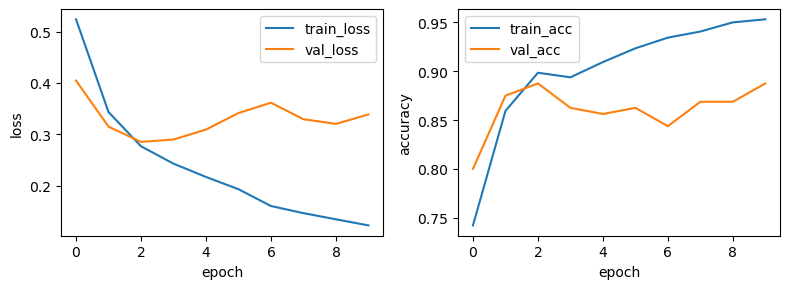

In [9]:
#plot the loss and accuracy curves
plt.figure(figsize=(8,3))
ax=plt.subplot(1,2,1)
ax.plot(losses)
ax.plot(val_losses)
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train_loss','val_loss'])
ax=plt.subplot(1,2,2)
ax.plot(accuracies)
ax.plot(val_accuracies)
ax.set_ylabel('accuracy')
ax.set_xlabel('epoch')
ax.legend(['train_acc','val_acc'])
plt.tight_layout()
plt.show()

In [10]:
# Save the trained model to a file
torch.save(model.state_dict(), 'protein_predictor_with_esm.pth')
print("Model saved to protein_predictor_with_esm.pth")

Model saved to protein_predictor_with_esm.pth


In [11]:
# If we're starting the notebook here, load the model from file
model=model_utils.ProteinPredictorWithESM(esm_model,esmlayer, hidden_dim=hiddendim)
model.load_state_dict(torch.load('protein_predictor_with_esm.pth'))
#esm_model.to_device(device)
_=model.to(device)
_=model.eval()
# Get the batch converter from the alphabet
batch_converter = alphabet.get_batch_converter()

In [12]:
#now get the attributions and predictions for all of the sequences
vis_loader=model_utils.makeDataLoader(df,batch_converter,
                                        colnames=['id','sequence','label'],shuffle=False)
attr_outputs,predictions=model_utils.evaluateSeqs(vis_loader,model,esm_model,esmlayer,device)

getting attributions for 0 length tensor([177])
getting attributions for 1 length tensor([304])
getting attributions for 2 length tensor([539])
getting attributions for 3 length tensor([203])
getting attributions for 4 length tensor([1091])
getting attributions for 5 length tensor([375])
getting attributions for 6 length tensor([202])
getting attributions for 7 length tensor([967])
getting attributions for 8 length tensor([264])
getting attributions for 9 length tensor([113])
getting attributions for 10 length tensor([84])
getting attributions for 11 length tensor([148])
getting attributions for 12 length tensor([264])
getting attributions for 13 length tensor([145])
getting attributions for 14 length tensor([73])
getting attributions for 15 length tensor([73])
getting attributions for 16 length tensor([185])
getting attributions for 17 length tensor([153])
getting attributions for 18 length tensor([972])
getting attributions for 19 length tensor([271])
getting attributions for 20 leng

In [13]:
#add our predictions to the worksheet and save for later
df['prediction']=predictions
df.to_csv('rna_binding_data_predictions.csv')

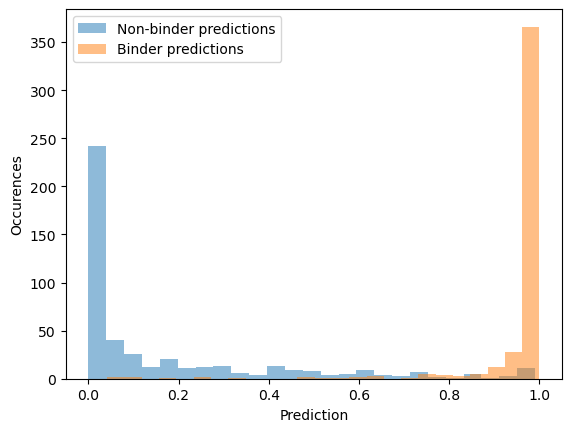

In [14]:
#now plot the positive and negative predictions
plt.hist(df[df['label']==0]['prediction'],bins=25,alpha=0.5)
plt.hist(df[df['label']==1]['prediction'],bins=25,alpha=0.5)
plt.legend(['Non-binder predictions','Binder predictions'])
plt.xlabel('Prediction')
plt.ylabel('Occurences')
plt.show()

In [15]:
#make the attributions into a matrix and save that
attrmat=np.full([len(df),2000],np.nan)
for i in range(len(df)):
    if(len(attr_outputs[i])>0):
        attrmat[i,:len(attr_outputs[i])]=attr_outputs[i]
np.save('rna_binding_data_attributions.npy',attrmat)

Text(0, 0.5, 'Test Sequence')

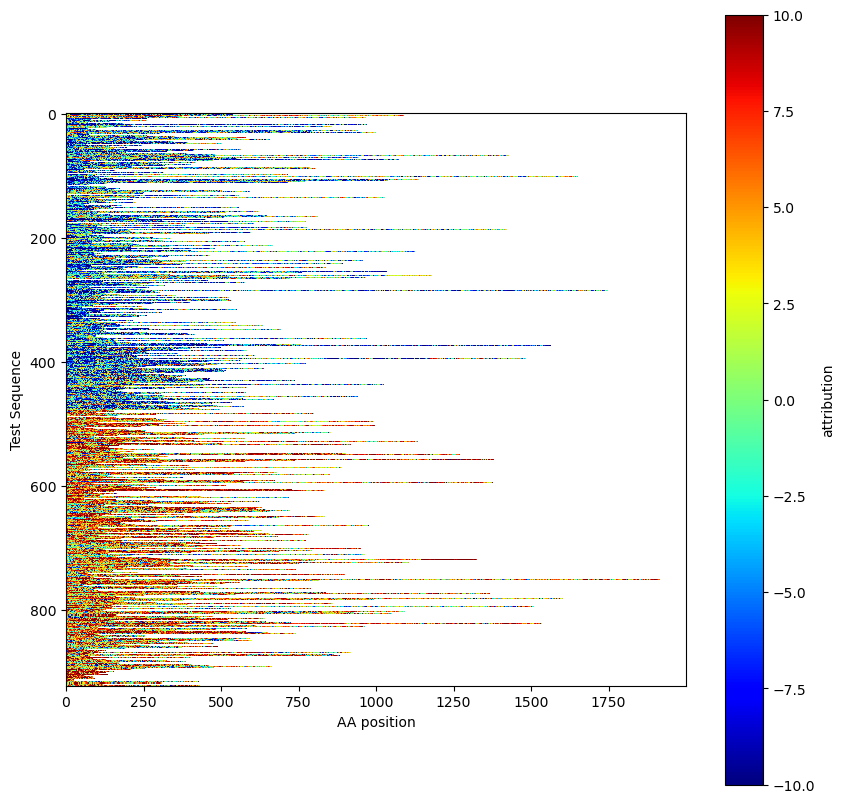

In [16]:
#now plot a heatmap of the attributions
plt.figure(figsize=(10,10))
plt.imshow(attrmat,cmap='jet',vmin=-10,vmax=10,interpolation='None',aspect=2.0)
plt.colorbar(label='attribution')
plt.xlabel('AA position')
plt.ylabel('Test Sequence')

selected id: sp|Q9Y4C8|RBM19_HUMAN
label: True prediction: 0.9992157220840454


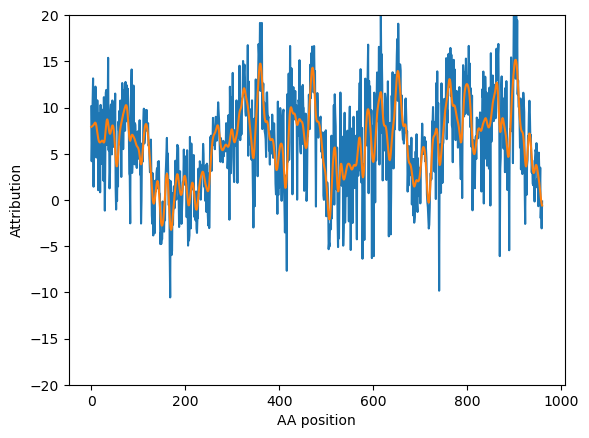

In [17]:
#show the attribution for a selected target
selidx=800
tid=df.loc[selidx,'id']
print('selected id:',tid)
print('label:',df.loc[selidx,'label'],'prediction:',df.loc[selidx,'prediction'])
seq=df.loc[selidx,'sequence']
seqlen=min(len(seq),2000)
attr=attrmat[selidx,:seqlen]
smattr=ndi.gaussian_filter(attr,sigma=3)
plt.plot(attr)
plt.plot(smattr)
plt.ylim(-20,20)
plt.xlabel('AA position')
plt.ylabel('Attribution')
plt.show()

In [18]:
#finally load the alphafold structure
selid=tid.split('|')[1]
print('getting af2 prediction for id',selid)
url='https://alphafold.ebi.ac.uk/files/AF-'+selid+'-F1-model_v4.pdb'
pdbstr=requests.get(url).text

getting af2 prediction for id Q9Y4C8


In [19]:
pdbdf=jutils.cleanpdbdf(jutils.jpt2.getpdbdffromstr(pdbstr))
pdbdf.head()

,type,atom,atype,resname,chain,residue,x,y,z,unk,temp,element
0,ATOM,1,N,MET,A,1,-20.164000,29.773001,-52.566002,1.0,60.060001,N
1,ATOM,2,CA,MET,A,1,-20.260000,28.389000,-52.049000,1.0,60.060001,C
2,ATOM,3,C,MET,A,1,-20.514999,28.457001,-50.561001,1.0,60.060001,C
3,ATOM,4,CB,MET,A,1,-18.985001,27.566000,-52.275002,1.0,60.060001,C
4,ATOM,5,O,MET,A,1,-19.749001,29.093000,-49.847000,1.0,60.060001,O


In [20]:
#map the smoothed attribution to the residues
resmap={i+1:smattr[i] for i in range(len(smattr))}
pdbdf['temp']=pdbdf['residue'].map(resmap)
_=jutils.writepdbdf(pdbdf,selid+'_mapped.pdb')

In [21]:
view=jutils.py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',width=600,height=600)
view.addModel(jutils.writepdbdf(pdbdf),'pdb')
#view.addModel(pdbstr,'pdb') #to view the raw AF data
view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':-10,'max':10}}})
#view.setStyle({'cartoon': {'color':'spectrum'}})
view.zoomTo()
view.show()

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

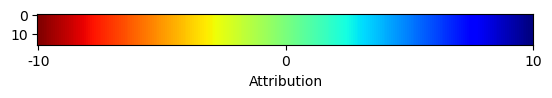

In [22]:
#show the color scale for the molecular plot
plt.imshow(np.tile(np.linspace(0,1,256),[16,1]),cmap='jet_r')
plt.xticks([0,128,256],[-10,0,10])
plt.xlabel('Attribution')
plt.show()